In [53]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import (
    Input,
    Sequential,
    layers,
    callbacks,
    optimizers,
)
from conlanger.models.WGANGP import WGANGP
from conlanger.utils import display_rows, get_closest_matches, get_exact_matches_indices
from IPython.display import display



In [54]:
USE_GPU = False
TRAIN = False

In [55]:
if USE_GPU:
    with tf.device('/gpu:0'):
        gpu = tf.config.list_physical_devices("GPU")
        if not gpu:
            raise

In [56]:
IMAGE_SIZE = 14
CHANNELS = 1
BATCH_SIZE = 512
Z_DIM = IMAGE_SIZE * IMAGE_SIZE
CRITIC_LEARNING_RATE = 0.0002
GENERATOR_LEARNING_RATE = 0.0008
EPOCHS = 600
CRITIC_STEPS = 5
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
NUM_LANGS = 100
STEPS_PER_EPOCH = 3
REPEAT_DATA = 30

In [57]:
data = np.load("./data/language_parameters.npz", allow_pickle=True)
language_parameters = data["language_parameters"]
languages = data["languages"]
parameters = data["parameters"]
parameter_columns = data["parameter_columns"]

l = language_parameters.shape[0]

X = np.hstack([language_parameters.copy(), np.zeros((l, 8))]).reshape(l, IMAGE_SIZE, IMAGE_SIZE)
X = np.expand_dims(X, axis=3)

MAX_VALUE = X.max()

X /= MAX_VALUE

assert language_parameters.shape[0] == languages.shape[0]

language_parameters.shape, languages.shape, parameters.shape, X.shape, Z_DIM

((852, 188), (852, 2), (188, 4), (852, 14, 14, 1), 196)

In [58]:
if TRAIN:
    critic = Sequential(
        [
            Input(shape=X.shape[1:]),
            layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=2, padding="same"),
            layers.LeakyReLU(0.1),
            layers.Conv2D(IMAGE_SIZE * 2, kernel_size=3, strides=2, padding="same"),
            layers.LeakyReLU(0.1),
            #layers.Dropout(0.1),
            layers.Conv2D(IMAGE_SIZE * 4, kernel_size=3, strides=2, padding="same"),
            layers.LeakyReLU(0.1),
            #layers.Dropout(0.1),
            layers.Conv2D(IMAGE_SIZE * 8, kernel_size=3, strides=2, padding="same"),
            layers.LeakyReLU(0.1),
            #layers.Dropout(0.1),
            layers.Conv2D(IMAGE_SIZE * IMAGE_SIZE, kernel_size=2, strides=1, padding="same"),
            layers.LeakyReLU(0.1),
            #layers.Dropout(0.1),
            layers.Flatten(),
        ],
        name="critic",
    )
    critic.summary()

In [59]:
if TRAIN:
    generator = Sequential(
        [
            Input(shape=(Z_DIM,)),
            layers.Reshape((1, 1, Z_DIM)),
            layers.Conv2DTranspose(
                IMAGE_SIZE * IMAGE_SIZE, kernel_size=4, strides=2, padding="valid", use_bias=False
            ),
            layers.GaussianDropout(0.4),
            layers.Conv2D(
                IMAGE_SIZE * 8, kernel_size=4, strides=2, padding="same", use_bias=False
            ),
            layers.BatchNormalization(momentum=0.9),
            layers.LeakyReLU(0.2),
            layers.GaussianDropout(0.4),
            layers.Conv2D(
                IMAGE_SIZE * 4, kernel_size=4, strides=2, padding="same", use_bias=False
            ),
            layers.BatchNormalization(momentum=0.9),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(
                IMAGE_SIZE * 2, kernel_size=4, strides=2, padding="same", use_bias=False
            ),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(
                IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False
            ),
            layers.GaussianDropout(0.4),
            layers.Conv2D(IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False),
            layers.BatchNormalization(momentum=0.9),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(
                IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False
            ),
            layers.GaussianDropout(0.4),
            layers.Conv2D(IMAGE_SIZE * 4, kernel_size=2, strides=4, padding="same", use_bias=False),
            layers.BatchNormalization(momentum=0.9),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(
                IMAGE_SIZE * IMAGE_SIZE, kernel_size=8, strides=1, padding="same", activation="sigmoid"
            ),
            layers.Reshape(X.shape[1:]),
        ],
        name="generator",
    )
    generator.summary()

In [60]:
# Create a GAN
if TRAIN:
    wgangp = WGANGP(
        critic=critic,
        generator=generator,
        latent_dim=Z_DIM,
        critic_steps=CRITIC_STEPS,
        gp_weight=GP_WEIGHT,
    )

In [61]:
# Compile the GAN
if TRAIN:
    wgangp.compile(
        c_optimizer=optimizers.Adam(
            learning_rate=CRITIC_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
        ),
        g_optimizer=optimizers.Adam(
            learning_rate=GENERATOR_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
        ),
    )

In [62]:
import matplotlib.pyplot as plt


class ImageGenerator(callbacks.Callback):
    def __init__(self, latent_dim, num_img=10, display_on_epoch=10, figsize=(28, 28)):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.display_on_epoch = display_on_epoch
        self.figsize = figsize

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.display_on_epoch == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors).numpy()
            plt.figure(figsize=self.figsize)

            for i in range(self.num_img):
                _ = plt.subplot(1, self.num_img, i + 1)
                plt.imshow(generated_images[i].astype("float32"), cmap="copper_r")
                plt.axis("off")
            
            plt.show()

In [63]:
if TRAIN:
    dataset = tf.data.Dataset.from_tensors(X.astype("float32")).repeat(REPEAT_DATA)

    history = wgangp.fit(
        dataset,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[
            ImageGenerator(latent_dim=Z_DIM),
        ],
    )

In [64]:
import matplotlib.pyplot as plt

if TRAIN:
    plt.plot(history.history['c_loss'])
    plt.plot(history.history['g_loss'])
    plt.title('GAN loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['critic', 'generator'], loc='upper left')
    plt.show()

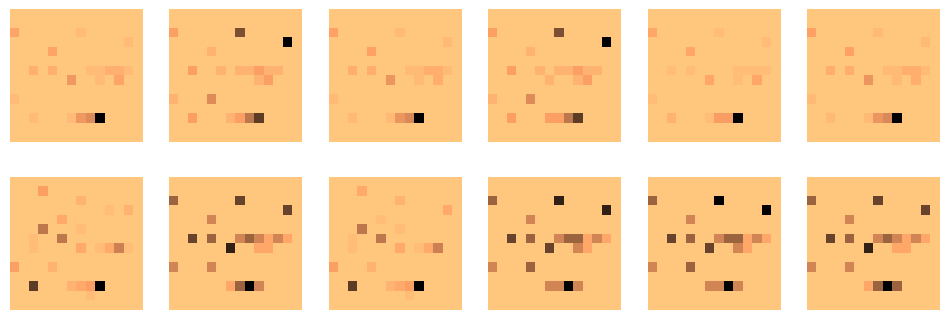

(100, 14, 14, 1)

In [65]:
if TRAIN:
    noise = np.random.normal(size=(NUM_LANGS, Z_DIM))
    generated_language_parameters = wgangp.generator.predict(noise)
    l = generated_language_parameters.shape[0]

    # normalise
    generated_language_parameters = (generated_language_parameters-np.min(generated_language_parameters))/(np.max(generated_language_parameters)-np.min(generated_language_parameters))

    # weirdness
    mean_lang = np.mean(X, axis=0).reshape(-1)
    diff_from_mean = np.array([np.mean(np.abs(mean_lang - g)) for g in generated_language_parameters])
    weirdness = np.round((diff_from_mean-np.min(diff_from_mean))/(np.max(diff_from_mean)-np.min(diff_from_mean)), decimals=2)

    np.savez_compressed(
        "./data/generated_language_parameters.npz",
        generated_language_parameters=generated_language_parameters,
        weirdness=weirdness
    )

else:
    data = np.load("./data/generated_language_parameters.npz", allow_pickle=True)
    generated_language_parameters = data["generated_language_parameters"]
    weirdness = data["weirdness"]
    l = generated_language_parameters.shape[0]

generated = (generated_language_parameters * MAX_VALUE).astype(int)

assert len(generated) == len(weirdness)

display_rows(generated, cmap="copper_r", r=2, c=6, size=(12, 4))

generated.shape

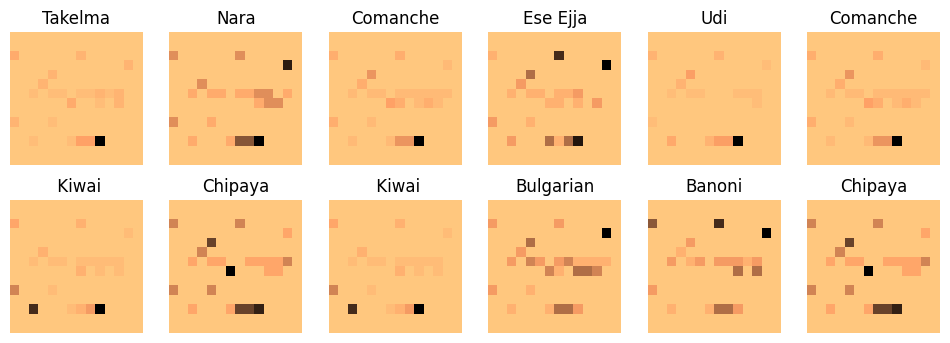

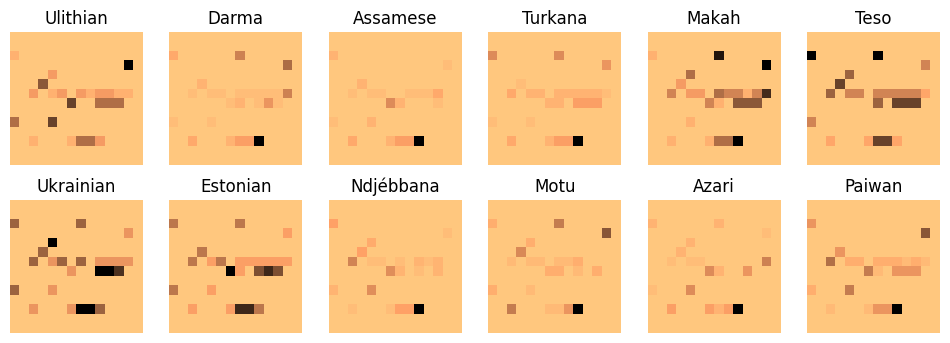

(0.07653061224489796, 0.16622448979591842, 0.6020408163265306)

In [66]:
# find closest matches
origin = (X * MAX_VALUE).astype(int)

closest_idx, closest, closest_diff = get_closest_matches(origin, generated, n=NUM_LANGS)
closest_language_names = np.take(languages[:, 1], closest_idx)

display_rows(closest, titles=closest_language_names, cmap="copper_r", r=2, c=6, size=(12, 4))

# random samples
gen = np.random.default_rng()
sample_indices = gen.choice(origin.shape[0], 12, replace=False)
samples = origin[sample_indices]
sample_names = languages[:, 1][sample_indices]

display_rows(samples, titles=sample_names, cmap="copper_r", r=2, c=6, size=(12, 4))

np.min(closest_diff), np.mean(closest_diff), np.max(closest_diff)

In [67]:
# find exact matches

exact_idx = get_exact_matches_indices(origin, generated)
exact = np.take(X, exact_idx)
exact_language_names = np.take(languages[:, 1], exact_idx)

if len(exact_idx) > 0:
    display_rows(exact, titles=exact_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))
else:
    print("No exact matches. Noice!")

origin.shape, exact_idx.shape

No exact matches. Noice!


((852, 14, 14, 1), (0,))

In [68]:
l = generated.shape[0]
w = parameters.shape[0]

generated_parameters = np.c_[
    np.tile(np.arange(l)[:, None, None], (1, w, 1)), 
    np.tile(parameters[:, 2:3], (l, 1, 1)), 
    generated.reshape(l, -1, 1)[:, 0:w]
].reshape((l*w, 3))

generated_parameters.shape, parameters.shape

((18800, 3), (188, 4))

In [69]:
from cldfbench import get_dataset

wals = get_dataset("wals").cldf_reader()

param_df = (
    pd.DataFrame(parameters, columns=parameter_columns)
    .set_index(["Area", "Chapter"])
)

display(param_df.head(3))

code_df = pd.DataFrame(wals.iter_rows("CodeTable"))[["Parameter_ID", "Name", "Description", "Number"]].rename(columns={"Parameter_ID":"ID"})

display(code_df.head(3))

ID                       Name
Area      Chapter                                                 
Phonology Consonant Inventories      1A      Consonant Inventories
          Vowel Quality Inventories  2A  Vowel Quality Inventories
          Consonant-Vowel Ratio      3A      Consonant-Vowel Ratio

,ID,Name,Description,Number
0,1A,Small,Small,1
1,1A,Moderately small,Moderately small,2
2,1A,Average,Average,3


In [74]:
generated_parameters_df = (pd.DataFrame(
    #generated_parameters[generated_parameters[:, 2] > 0], 
    generated_parameters, 
    columns=["Gen_Lang", "ID", "Gen_Number"]
    ).merge(param_df[["ID"]].reset_index(), on="ID", how="left"))

codes = code_df.to_numpy()
generated_codes = generated_parameters_df[["ID", "Gen_Number"]].to_numpy()
closest_matched_codes = [codes[codes[:, 0] == c[0]][(np.abs(codes[codes[:, 0] == c[0]][:, 3] - c[1])).argmin(), 1:4] for c in generated_codes]

closest_matched_codes_df = pd.DataFrame(closest_matched_codes, columns=["Name", "Description", "Matched_Number"])

generated_parameters_df = pd.concat([generated_parameters_df,closest_matched_codes_df],axis=1)[["Gen_Lang", "ID", "Gen_Number", "Matched_Number", "Area", "Chapter", "Name", "Description"]]
generated_parameters_df.loc[generated_parameters_df["Gen_Number"] == 0, "Matched_Number"] = 0
generated_parameters_df["exact_match"] = generated_parameters_df.Gen_Number == generated_parameters_df.Matched_Number

selected_parameters_df = (
    generated_parameters_df.loc[generated_parameters_df["Gen_Number"] > 0]
    .set_index(["Gen_Lang", "Area", "Chapter"])
)
selected_parameters_df[selected_parameters_df.index.get_level_values("Gen_Lang") == 5].groupby(level=[0, 1, 2]).head(10)

ID  \
Gen_Lang Area                  Chapter                                                    
5        Morphology            Prefixing vs. Suffixing in Inflectional Morphology   26A   
         Nominal Categories    Coding of Nominal Plurality                          33A   
                               Position of Case Affixes                             51A   
                               Position of Pronominal Possessive Affixes            57A   
         Word Order            Order of Subject, Object and Verb                    81A   
                               Order of Subject and Verb                            82A   
                               Order of Genitive and Noun                           86A   
                               Order of Adjective and Noun                          87A   
                               Order of Demonstrative and Noun                      88A   
                               Order of Numeral and Noun                            89A   
                               Order of Relative Clause and Noun                    90A   
                               Position of Polar Question Particles                 92A   
                               Relationship between the Order of Object and Ve...   95A   
                               Relationship between the Order of Object and Ve...   97A   
         Simple Clauses        Negative Morphemes                                  112A   
         Word Order - Negation Order of Negative Morpheme and Verb                 143A   
                               Order of Negative Morpheme and Verb                 143E   
                               Order of Negative Morpheme and Verb                 143F   
                               Order of Negative Morpheme and Verb                 143G   
                               Position of Negative Morpheme With Respect to S...  144A   

                                                                                  Gen_Number  \
Gen_Lang Area                  Chapter                                                         
5        Morphology            Prefixing vs. Suffixing in Inflectional Morphology          3   
         Nominal Categories    Coding of Nominal Plurality                                 1   
                               Position of Case Affixes                                    1   
                               Position of Pronominal Possessive Affixes                   3   
         Word Order            Order of Subject, Object and Verb                           2   
                               Order of Subject and Verb                                   2   
                               Order of Genitive and Noun                                  1   
                               Order of Adjective and Noun                                 1   
                               Order of Demonstrative and Noun                             2   
                               Order of Numeral and Noun                                   2   
                               Order of Relative Clause and Noun                           1   
                               Position of Polar Question Particles                        4   
                               Relationship between the Order of Object and Ve...          1   
                               Relationship between the Order of Object and Ve...          2   
         Simple Clauses        Negative Morphemes                                          1   
         Word Order - Negation Order of Negative Morpheme and Verb                         1   
                               Order of Negative Morpheme and Verb                         1   
                               Order of Negative Morpheme and Verb                         4   
                               Order of Negative Morpheme and Verb                         5   
                               Position of Negative Morpheme With 

In [71]:
selected_parameters_df.exact_match.value_counts()

exact_match
True     1906
False     146
Name: count, dtype: int64

In [73]:
# check we have the corrct number of generated languages
assert len(selected_parameters_df.index.get_level_values("Gen_Lang").unique()) == len(generated) == len(weirdness)